In [1]:
%load_ext autoreload

In [576]:
%autoreload

from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import torch
from gaul import advi, hmc, quap
from jax.example_libraries import stax
from jax.scipy import special, stats
from pears import pears
from tqdm.auto import tqdm

In [705]:
def mesh_eval(func, x_limits, y_limits, num_ticks):
    x = jnp.linspace(*x_limits, num_ticks)
    y = jnp.linspace(*y_limits, num_ticks)
    X, Y = jnp.meshgrid(x, y)
    xy_vec = jnp.stack([X.ravel(), Y.ravel()]).T
    zs = jax.vmap(func)(xy_vec)
    return X, Y, zs.reshape(X.shape)

In [706]:
@jax.jit
def log_density_mixture(x):
    params = (
        jnp.zeros(2),
        jnp.eye(2) / 2,
        jnp.ones(2) * 2,
        jnp.eye(2),
        0.6,
        0.4,
    )
    mean1, cov1, mean2, cov2, a, b = params
    return special.logsumexp(
        jnp.stack(
            (
                jnp.log(a) + stats.multivariate_normal.logpdf(x, mean=mean1, cov=cov1),
                jnp.log(b) + stats.multivariate_normal.logpdf(x, mean=mean2, cov=cov2),
            )
        ),
        axis=0,
    )

In [731]:
@jax.jit
def log_density_banana(x):
    params = (jnp.array([0, 2]), jnp.array([[1, 0.5], [0.5, 1]]), 2, 0.2)
    mean, cov, a, b = params
    y = jnp.array([x[0] / a, x[1] * a + a * b * (x[0] * x[0] + a * a)])
    return stats.multivariate_normal.logpdf(y, mean=mean, cov=cov).sum()

In [724]:
@jax.jit
def log_density_ring(z):
    norm = jnp.sqrt(z[0] ** 2 + z[1] ** 2)
    exp1 = jnp.exp(-0.5 * ((z[0] - 2) / 1.1) ** 2)
    exp2 = jnp.exp(-0.5 * ((z[0] + 2) / 1.1) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - jnp.log(exp1 + exp2)

    return -u.sum()

In [725]:
@jax.jit
def log_density_eggbox(z):
    tmax = 5.0 * jnp.pi
    t = 2.0 * tmax * z - tmax
    return (2.0 + jnp.cos(t[0] / 2.0) * jnp.cos(t[1] / 2.0)) ** 5.0

In [711]:
@jax.jit
def log_density_circle(z):
    r = 1.0  # radius
    w = 0.1  # width
    c = jnp.zeros(2)  # center of shell
    const = jnp.log(1.0 / jnp.sqrt(2.0 * jnp.pi * w**2))  # normalization constant

    d = jnp.sqrt(jnp.sum((z - c) ** 2, axis=-1))  # |theta - c|
    return const - (d - r) ** 2 / (2.0 * w**2)

In [712]:
ndim = 25
C = jnp.ones((ndim, ndim)) * 0.7
for i in range(ndim):
    C = C.at[i, i].set(1.0)


@jax.jit
def log_density_corr_mvn(z):
    return stats.multivariate_normal.logpdf(z, jnp.zeros(ndim), C).sum()

CPU times: user 662 ms, sys: 4.38 ms, total: 666 ms
Wall time: 231 ms


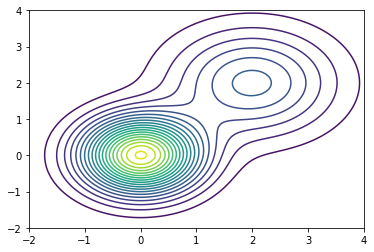

In [713]:
%%time
X, Y, Z = mesh_eval(
    log_density_mixture,
    (-2, 4),
    (-2, 4),
    100,
)
plt.contour(X, Y, jnp.exp(Z), levels=20);

CPU times: user 302 ms, sys: 7.62 ms, total: 310 ms
Wall time: 223 ms


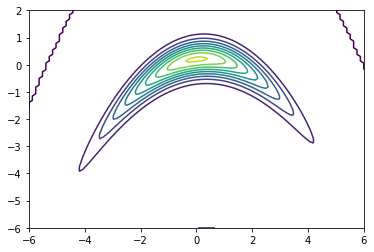

In [732]:
%%time
X, Y, Z = mesh_eval(
    log_density_banana,
    (-6, 6),
    (-6, 2),
    100,
)
plt.contour(X, Y, jnp.exp(Z), levels=10)

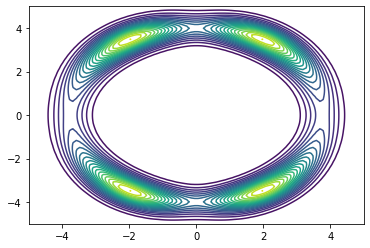

In [733]:
X, Y, Z = mesh_eval(log_density_ring, (-5, 5), (-5, 5), 100)
plt.contour(X, Y, jnp.exp(Z), levels=20)

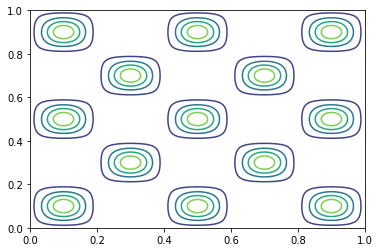

In [734]:
X, Y, Z = mesh_eval(log_density_eggbox, (0.0, 1.0), (0.0, 1.0), 100)
plt.contour(X, Y, Z, levels=5)

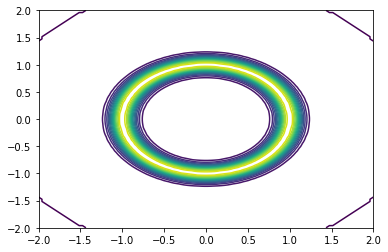

In [735]:
X, Y, Z = mesh_eval(log_density_circle, (-2, 2), (-2, 2), 100)
plt.contour(X, Y, jnp.exp(Z), levels=15)

In [501]:
def safe_log(x):
    return jnp.log(x + 1e-7)


class PlanarFlow(eqx.Module):

    weight: jnp.ndarray
    bias: jnp.ndarray
    scale: jnp.ndarray

    def __init__(self, dim, key):
        super().__init__()
        keys = jax.random.split(key, 3)

        self.weight = jax.random.uniform(keys[0], (1, dim)) * 0.01
        self.bias = jax.random.uniform(keys[1], (1,)) * 0.01
        self.scale = jax.random.uniform(keys[2], (1, dim)) * 0.01

    @jax.jit
    def __call__(self, z):
        activation = z @ self.weight.T + self.bias
        return z + self.scale * jnp.tanh(activation)

    @jax.jit
    def logdetjac(self, z):
        activation = z @ self.weight.T + self.bias
        psi = (1 - jnp.tanh(activation) ** 2) * self.weight
        det_grad = 1 + psi @ self.scale.T
        return safe_log(jnp.abs(det_grad))


class NF(eqx.Module):

    dim: int
    flow_length: int
    transforms: list

    def __init__(self, dim, flow_length, key):
        super().__init__()

        keys = jax.random.split(key, flow_length)

        self.dim = dim
        self.flow_length = flow_length
        self.transforms = [PlanarFlow(dim, keys[i]) for i in range(flow_length)]

    @jax.jit
    def __call__(self, z):

        log_jacobians = []

        for t in self.transforms[:-1]:
            log_jacobians.append(t.logdetjac(z))
            z = t(z)

        return z, jnp.concatenate(log_jacobians)

In [785]:
@eqx.filter_value_and_grad
def compute_loss(model, z):
    zk, logjac = model(z)
    loss = jnp.nanmean(-jnp.nansum(logjac) - jax.vmap(log_density_banana)(zk))
    return loss

In [786]:
@eqx.filter_jit
def run_step(model, z, optimizer, opt_state):
    loss, grads = compute_loss(model, z)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [787]:
key = jax.random.PRNGKey(0)

In [789]:
ndim = 2
flow_len = 5
flow = NF(ndim, flow_len, key)

In [790]:
schedule = optax.exponential_decay(1e-2, 1000, 0.999)
optim = optax.chain(
    optax.clip(1.0),
    optax.adam(schedule),
)
opt_state = optim.init(flow)

In [791]:
nsteps = 5000
batch_size = 128
keys = jax.random.split(key, nsteps)

losses = []

for i in (pbar := tqdm(range(nsteps))):
    z = jax.random.normal(keys[i], shape=(batch_size, ndim))
    loss, flow, opt_state = run_step(flow, z, optim, opt_state)
    loss = loss.item()
    losses.append(loss)
    if i % 200 == 0:
        pbar.set_description(f"step={i + 1}, loss={loss}")

  0%|          | 0/5000 [00:00<?, ?it/s]

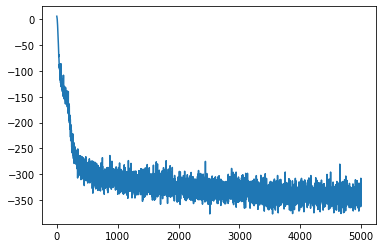

In [792]:
plt.plot(jnp.array(losses))

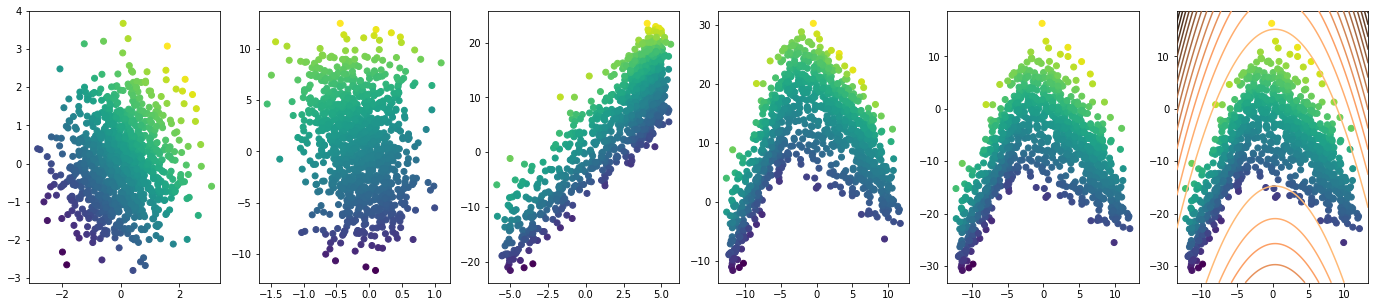

In [793]:
fig, ax = plt.subplots(1, flow_len + 1, figsize=((flow_len + 1) * 4, 5))
z = jax.random.normal(key, shape=(1000, ndim))
c = jnp.sum(z, axis=1)
ax[0].scatter(z[:, 0], z[:, 1], c=c)
for k in range(flow_len):
    z = flow.transforms[k](z)
    ax[k + 1].scatter(z[:, 0], z[:, 1], c=c)
X, Y, Z = mesh_eval(
    log_density_banana,
    ax[k + 1].get_xlim(),
    ax[k + 1].get_ylim(),
    100,
)
ax[k + 1].contour(X, Y, Z, levels=15, zorder=5, cmap="copper")

In [796]:
samples = hmc.sample(
    log_density_banana,
    jnp.array([0.5, 0.5]),
    step_size=0.05,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

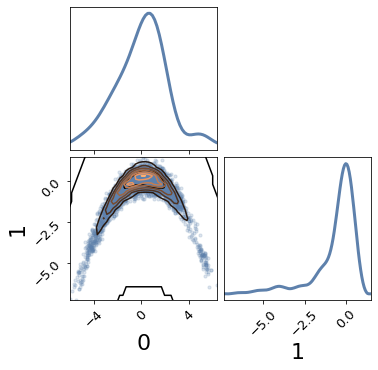

In [797]:
fig, ax = pears(samples.transpose(1, 0, 2), kde_color="black")
ax[1, 0].contour(X, Y, jnp.exp(Z), cmap="copper");